<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Templates/Prophet%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Non Common Modules

In [1]:
!pip install Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

Importing the data from CSV.  
Change to Local address if using Jupyter.  
Use raw url is using collab


In [3]:
data_url ="https://raw.githubusercontent.com/Coresight-Adithya/Automated-Projections/main/Food%20at%20Home%20CPI%20US/Food%20At%20Home%20CPI.csv" 
data_name = "Food at home"
df = pd.read_csv(data_url)
print(df)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') + MonthEnd(1)
df.columns = ['ds', 'y']
df['y'] = df['y'].astype(float)
df = df.dropna()

           Date   Sales 
0    01-01-2010  215.404
1    01-02-2010  215.118
2    01-03-2010  215.623
3    01-04-2010  215.737
4    01-05-2010  215.793
..          ...      ...
145  01-02-2022  274.568
146  01-03-2022  278.612
147  01-04-2022  282.161
148  01-05-2022  285.953
149  01-06-2022  288.884

[150 rows x 2 columns]


Alternative way of getting data from API   
Change the Number to the NAISC code of the relevant one from the Census bureau  


In [4]:
!pip install pymysql

from sqlalchemy import create_engine
from urllib.parse import quote

# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='445'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 


Removing Covid outliers if required

In [5]:
# COVID Outliers
covid_outlier_st = datetime.strptime('2020-03-31', '%Y-%m-%d').date()
covid_outlier_en = datetime.strptime('2020-05-31', '%Y-%m-%d').date()

df.loc[(df['ds'].dt.date >= covid_outlier_st) & (df['ds'].dt.date <= covid_outlier_en), 'y'] = None

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


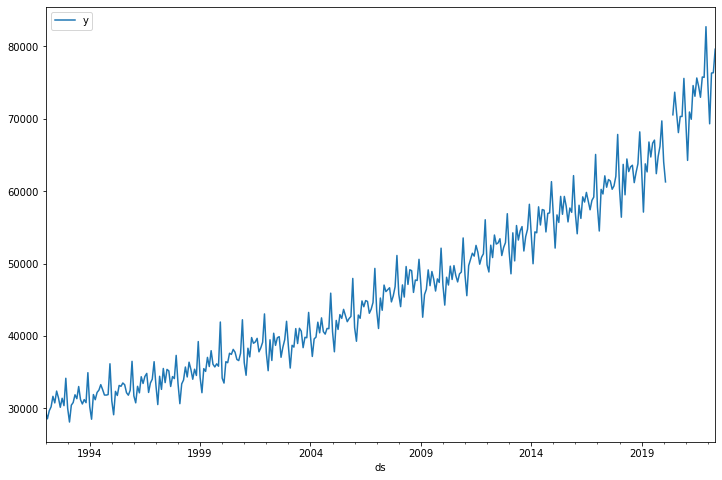

In [6]:
df.plot(x='ds', y='y', figsize=(12,8))

Change season_mode to additive if above graph looks like  

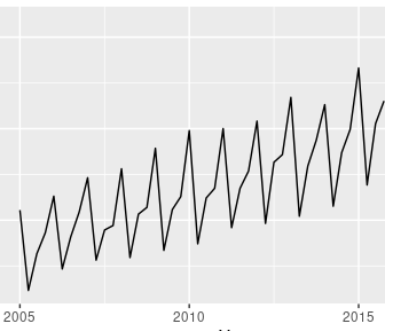

Change season_mode to Multiplicative if above graph looks like 

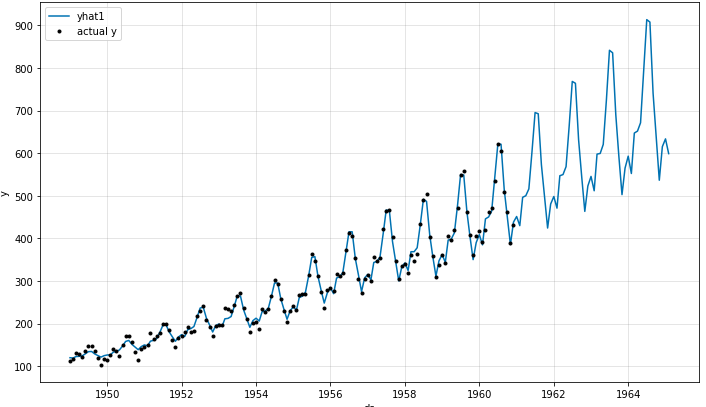

In [7]:
season_mode = "multiplicative"

In [8]:
# Facebook Prophet Model
model = Prophet(seasonality_mode=season_mode, daily_seasonality=False, weekly_seasonality=False)
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj06uz8oq/k4jw58sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj06uz8oq/q8hd6krs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9143', 'data', 'file=/tmp/tmpj06uz8oq/k4jw58sf.json', 'init=/tmp/tmpj06uz8oq/q8hd6krs.json', 'output', 'file=/tmp/tmp4bpjkz_5/prophet_model-20220812062921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
# Make future dates
future = model.make_future_dataframe(periods=68, freq='M')
future = future[future['ds'].dt.year <= datetime.now().year+6]
future

,ds
0,1992-01-31
1,1992-02-29
2,1992-03-31
3,1992-04-30
4,1992-05-31
...,...
428,2027-09-30
429,2027-10-31
430,2027-11-30
431,2027-12-31


In [10]:
# Forecast
forecast = model.predict(future)

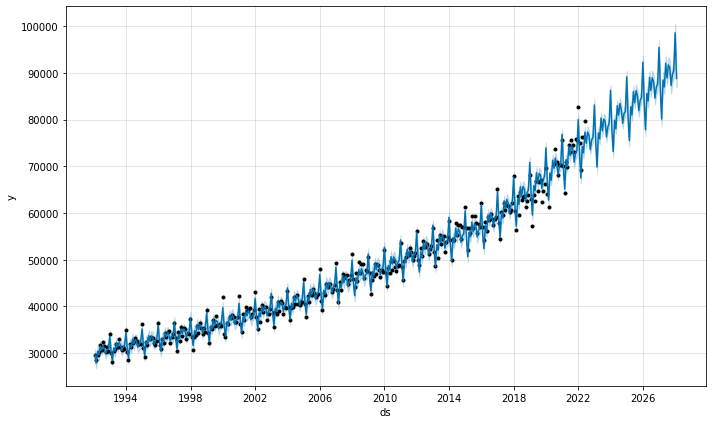

In [11]:
model.plot(forecast);

Judge the output of the model vs the actuals.  
Dots are Actual and blue line is Predicted. 
Use this model if the latest values are in a good fit with the data. 

Example below of a good fit

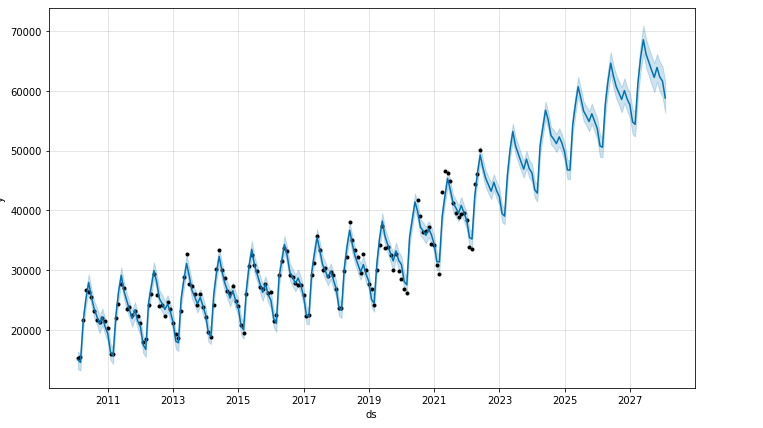


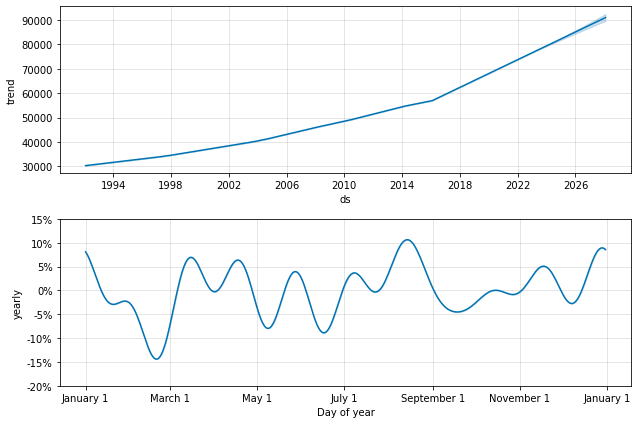

In [12]:
model.plot_components(forecast);

Converting model values into CSV for export

In [ ]:
data_name = "Enter sector name here"
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].to_csv(data_name+'-Prophet-Predictions.csv')